In [12]:
import numpy as np
import pandas as pd

import torch
from PIL import Image
from torchvision import models
import torch.nn as nn
from torch import FloatTensor, LongTensor

import seaborn as sns
import plotly.express as px
from matplotlib import colors
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

import os
import gc
import cv2
import json
import time
from tqdm import tqdm

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [13]:
import json
import os
from os.path import join as path_join


def load_data(path):
    tasks = pd.Series()
    for file_path in os.listdir(path):
        task_file = path_join(path, file_path)

        with open(task_file, 'r') as f:
            task = json.load(f)

        tasks[file_path[:-5]] = task
    return tasks

In [14]:
train_tasks = load_data('../input/abstraction-and-reasoning-challenge/training/')
test_tasks = load_data('../input/abstraction-and-reasoning-challenge/test/')

train_tasks.head()

780d0b14    {'train': [{'input': [[1, 1, 1, 1, 0, 0, 1, 1,...
a1570a43    {'train': [{'input': [[3, 0, 2, 0, 0, 0, 3], [...
d90796e8    {'train': [{'input': [[3, 2, 0], [0, 0, 0], [0...
3f7978a0    {'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...
22eb0ac0    {'train': [{'input': [[0, 0, 0, 0, 0, 0, 0, 0,...
dtype: object

In [15]:
def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img

def resize_to_224x224_pil(img):
    # Initialize an empty array to hold the resized channels
    resized_img = np.zeros((10, 224, 224), dtype=np.uint8)
    
    # Iterate over each channel (depth) of the image
    for i in range(img.shape[0]):
        # Convert the 2D array to a PIL Image
        channel_img = Image.fromarray(img[i])
        
        # Resize to (224, 224) using nearest-neighbor interpolation
        resized_channel = channel_img.resize((224, 224), Image.NEAREST)
        
        # Convert back to numpy and store in the resized array
        resized_img[i] = np.array(resized_channel)
    
    return resized_img

In [16]:
class TaskSolver:
    def train(self, task_train, n_epoch=10):
        """Basic PyTorch train loop with modified ResNet for 10-channel input"""
        # Load pre-trained ResNet
        self.net = models.resnet18(pretrained=False)
        
        # Modify the first convolutional layer to accept 10 channels
        self.net.conv1 = nn.Conv2d(
            in_channels=10,  # Number of input channels
            out_channels=64,  # Keep the same number of output channels
            kernel_size=7, 
            stride=2, 
            padding=3, 
            bias=False
        )
        
        # Remove the fully connected layer
        self.net = nn.Sequential(*list(self.net.children())[:-2])
        
        # Add your custom layers
        self.conv1 = nn.Conv2d(in_channels=512, out_channels=10, kernel_size=1, stride=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv2 = nn.Conv2d(10, 10, kernel_size=1)
        
        criterion = nn.MSELoss()
        optimizer = Adam(self.net.parameters(), lr=0.1)

        self.total_loss = 0
        
        for epoch in range(n_epoch):
            epoch_loss = 0
            for sample in task_train:
                # Preprocess inputs and labels
                inputs = FloatTensor(resize_to_224x224_pil(inp2img(sample['input']))).unsqueeze(dim=0)
                labels = FloatTensor(sample['output']).unsqueeze(dim=0)

                
                optimizer.zero_grad()
                # print(inputs.shape)  # Debugging statement
                
                # Forward pass
                res_out = self.net(inputs)  # Output will retain spatial dimensions
                conv1_out = self.conv1(res_out)
                pool_out = self.pool(conv1_out)
                output = self.conv2(pool_out)
                
                # Compute loss
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            self.total_loss += epoch_loss / len(task_train)
        print(f"Average Loss after Task: {self.total_loss / n_epoch :0.4f}")
        return self
    def predict(self, task_test):
        predictions = []
        with torch.no_grad():
            for sample in task_test:
                inputs = FloatTensor(resize_to_224x224_pil(inp2img(sample['input']))).unsqueeze(dim=0)
                res_out = self.net(inputs)
                conv1_out = self.conv1(res_out)
                pool_out = self.pool(conv1_out)
                output = self.conv2(pool_out)
                pred =  output.squeeze(dim=0).cpu().numpy().argmax(0)
                predictions.append(pred)
                                     
        return predictions

In [17]:
def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])

In [18]:
def evaluate(tasks):
    # ts = TaskSolver()
    result = []
    predictions = []
    loss_tracker = []
    for task in tqdm(tasks):
        ts = TaskSolver()
        if input_output_shape_is_same(task):
            ts.train(task['train'])
            loss_tracker.append(ts.total_loss / 10)
            pred = ts.predict(task['test'])
            # score = calk_score(task['test'], pred
        else:
            pred = [el['input'] for el in task['test']]
            score = [0]*len(task['test'])
        
        predictions.append(pred)
        # result.append(score)
       
    return predictions, loss_tracker

In [19]:
train_predictions, training_loss_tracker = evaluate(train_tasks[0:30])

  0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 7, 7])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target

Average Loss after Task: 0.9934


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 3, 3])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 7, 6])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|█         | 3/30 [00:18<02:49,  6.28s/it]

Average Loss after Task: 5.8636


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 10, 10])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 17%|█▋        | 5/30 [00:25<01:59,  4.76s/it]

Average Loss after Task: 4.2064


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 21, 21])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 30%|███       | 9/30 [00:32<01:02,  2.98s/it]

Average Loss after Task: 4.3798


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 20, 20])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 23, 23])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 37%|███▋      | 11/30 [00:41<01:04,  3.40s/it]

Average Loss after Task: 10.4869


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 24, 24])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 27, 27])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 53%|█████▎    | 16/30 [00:48<00:33,  2.40s/it]

Average Loss after Task: 11.2164


 67%|██████▋   | 20/30 [00:55<00:21,  2.16s/it]

Average Loss after Task: 0.3667


 80%|████████  | 24/30 [01:00<00:11,  1.85s/it]

Average Loss after Task: 0.4882


 87%|████████▋ | 26/30 [01:11<00:10,  2.57s/it]

Average Loss after Task: 0.9825


 93%|█████████▎| 28/30 [01:18<00:05,  2.82s/it]

Average Loss after Task: 2.8212


 97%|█████████▋| 29/30 [01:26<00:03,  3.40s/it]

Average Loss after Task: 3.8147


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 11, 11])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 30/30 [01:35<00:00,  3.19s/it]

Average Loss after Task: 6.3585


In [20]:
training_loss_tracker

[0.9933572426438332,
 5.863551934560141,
 4.206403934955596,
 4.3797688762346905,
 10.486900726954143,
 11.21642189025879,
 0.3667069931825002,
 0.4882083609700203,
 0.9824706077575683,
 2.8212296247482302,
 3.814709834257762,
 6.358454692363739]

In [21]:
average_training_loss_tracker = []
cumulative_sum = 0
for i, val in enumerate(training_loss_tracker, start=1):
    cumulative_sum += val
    average_training_loss_tracker.append(cumulative_sum / i)

average_training_loss_tracker

[0.9933572426438332,
 3.428454588601987,
 3.6877710373865233,
 3.860770497098565,
 5.18599654306968,
 6.191067434267865,
 5.35901594268424,
 4.750164994969963,
 4.331532285279697,
 4.18050201922655,
 4.147248184229388,
 4.331515393240584]

**VALIDATION**

In [22]:
val_predictions, val_loss_tracker = evaluate(train_tasks[60:90])


  3%|▎         | 1/30 [00:06<02:54,  6.00s/it]

Average Loss after Task: 1.1666


  7%|▋         | 2/30 [00:17<04:22,  9.38s/it]

Average Loss after Task: 5.7066


 10%|█         | 3/30 [00:22<03:19,  7.39s/it]

Average Loss after Task: 1.0236


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 19, 12])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 12, 14])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 15, 15])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have th

Average Loss after Task: 8.2105


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 13, 15])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 12, 11])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 12, 13])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have th

Average Loss after Task: 6.9439


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 6, 6])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 23%|██▎       | 7/30 [00:46<02:12,  5.75s/it]

Average Loss after Task: 6.4760


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 8, 9])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 7, 9])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 27%|██▋       | 8/30 [00:53<02:14,  6.11s/it]

Average Loss after Task: 1.6676


 30%|███       | 9/30 [01:01<02:18,  6.62s/it]

Average Loss after Task: 3.1162


 33%|███▎      | 10/30 [01:06<02:05,  6.26s/it]

Average Loss after Task: 7.8871


 43%|████▎     | 13/30 [01:17<01:20,  4.73s/it]

Average Loss after Task: 3.4471


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 22, 25])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 24, 21])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 50%|█████     | 15/30 [01:24<01:05,  4.34s/it]

Average Loss after Task: 6.0992


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 3, 5])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 57%|█████▋    | 17/30 [01:34<00:59,  4.58s/it]

Average Loss after Task: 6.0946


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 8, 8])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 60%|██████    | 18/30 [01:42<01:03,  5.29s/it]

Average Loss after Task: 3.5868


 63%|██████▎   | 19/30 [01:47<00:57,  5.20s/it]

Average Loss after Task: 2.6610


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 14, 14])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 17, 14])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 17, 16])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have th

Average Loss after Task: 3.7546


 70%|███████   | 21/30 [02:05<01:00,  6.74s/it]

Average Loss after Task: 0.5093


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 14, 12])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 73%|███████▎  | 22/30 [02:13<00:55,  6.97s/it]

Average Loss after Task: 0.3140


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 5, 5])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 77%|███████▋  | 23/30 [02:21<00:50,  7.20s/it]

Average Loss after Task: 1.7693


 80%|████████  | 24/30 [02:28<00:43,  7.27s/it]

Average Loss after Task: 6.2529


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 10, 4])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 87%|████████▋ | 26/30 [02:33<00:20,  5.21s/it]

Average Loss after Task: 12.9664


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 17, 17])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 93%|█████████▎| 28/30 [02:41<00:09,  4.68s/it]

Average Loss after Task: 3.4824


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 16, 16])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 97%|█████████▋| 29/30 [02:51<00:05,  5.91s/it]

Average Loss after Task: 13.1798


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 8, 30])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 8, 20])) that is different to the input size (torch.Size([1, 10, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 30/30 [02:56<00:00,  5.90s/it]

Average Loss after Task: 8.2454


In [24]:
val_loss_tracker

23

In [25]:
average_val_loss_tracker = []
cumulative_sum = 0
for i, val in enumerate(val_loss_tracker, start=1):
    cumulative_sum += val
    average_val_loss_tracker.append(cumulative_sum / i)

average_val_loss_tracker

[1.16662358045578,
 3.4366335141658775,
 2.6323017827669775,
 4.026858619252841,
 4.610257636229197,
 4.92121356288592,
 4.456415400278,
 4.288887086212635,
 4.688684004942576,
 4.564523138761521,
 4.7040382130218275,
 4.8199207245972415,
 4.725067151479232,
 4.5776367570388885,
 4.522769197596444,
 4.271928642727435,
 4.039110989231689,
 3.9130089079671433,
 4.036163442155771,
 4.482673656125863,
 4.43504389427957,
 4.832534718134186,
 4.98092047198959]

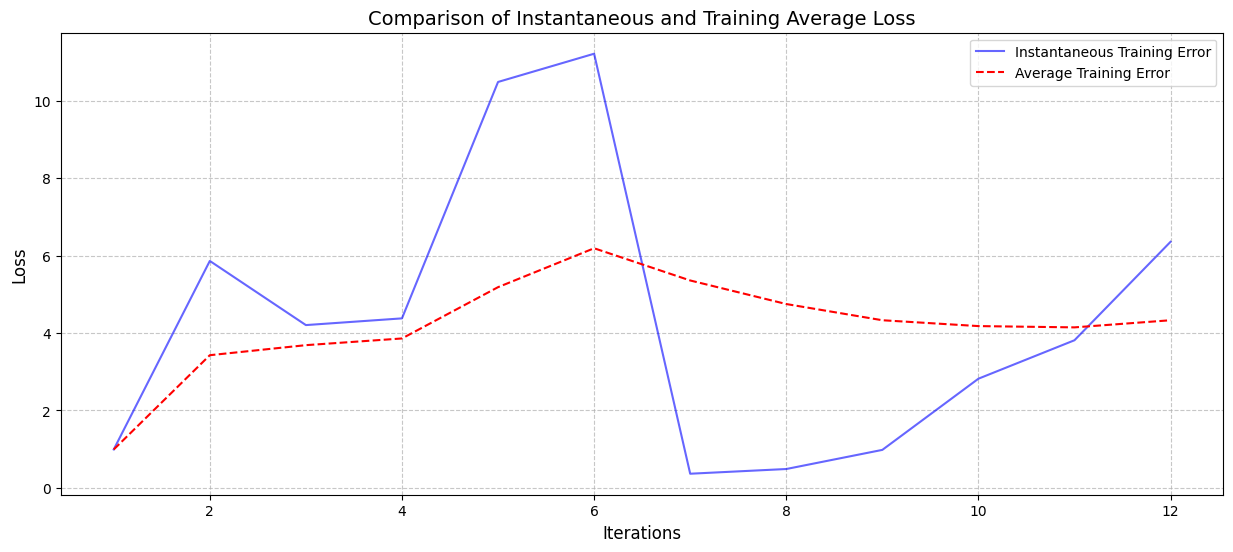

In [26]:
iterations_tr = np.arange(1, 13)

plt.figure(figsize=(15, 6))
plt.plot(iterations_tr, training_loss_tracker, label='Instantaneous Training Error', color='blue', alpha=0.6)
plt.plot(iterations_tr, average_training_loss_tracker, label='Average Training Error', color='red', linestyle='--')

plt.title('Comparison of Instantaneous and Training Average Loss', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

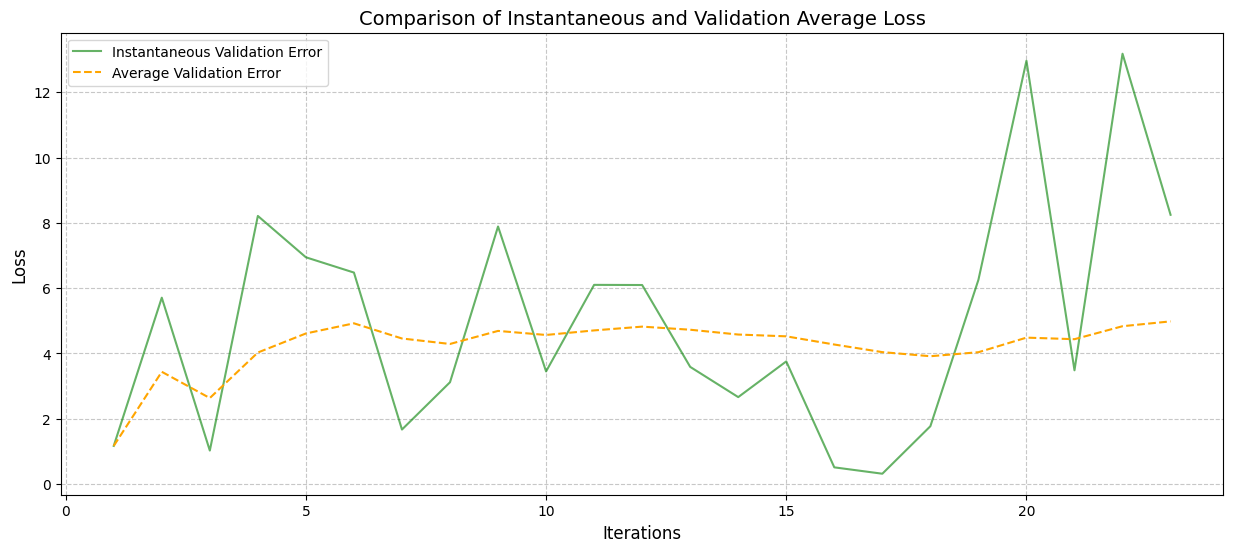

In [27]:
iterations_val = np.arange(1, 24)

plt.figure(figsize=(15, 6))
plt.plot(iterations_val, val_loss_tracker, label='Instantaneous Validation Error', color='green', alpha=0.6)
plt.plot(iterations_val, average_val_loss_tracker, label='Average Validation Error', color='orange', linestyle='--')

plt.title('Comparison of Instantaneous and Validation Average Loss', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

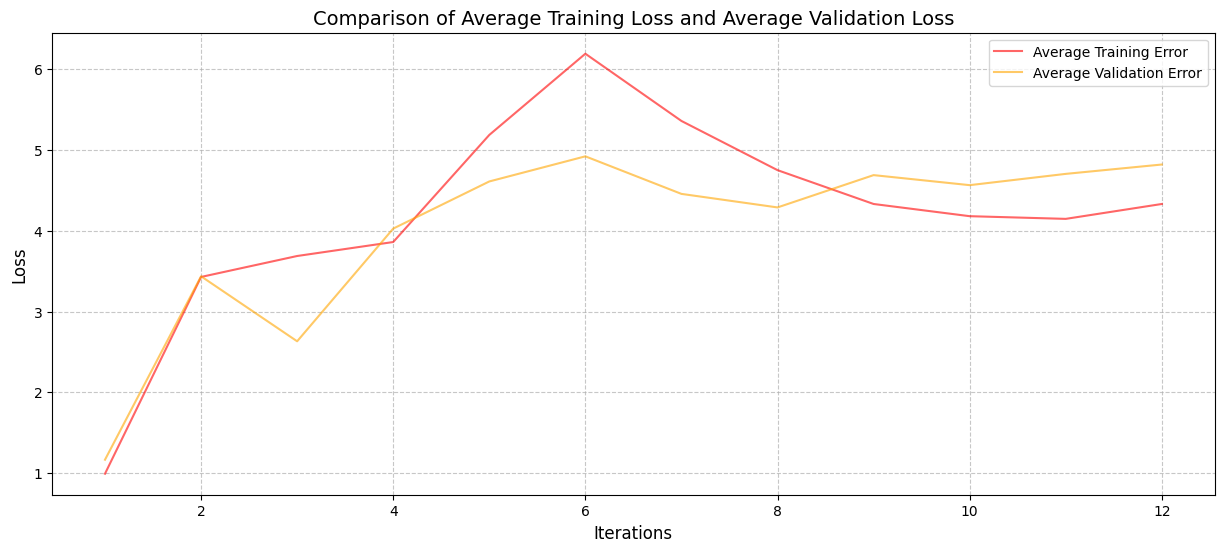

In [30]:
plt.figure(figsize=(15, 6))
plt.plot(iterations_tr, average_training_loss_tracker, label='Average Training Error', color='red', alpha=0.6)
plt.plot(iterations_tr, average_val_loss_tracker[0:12], label='Average Validation Error', color='orange', alpha = 0.6)

plt.title('Comparison of Average Training Loss and Average Validation Loss', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)